In [1]:
import networkx as nx
import time
import pandas as pd
import numpy as np
import stanza

In [2]:
# A sample sentence from biomedical domain is used to demonstrate the approach
sent = 'In contrast, the product of the human CDKN2A beta transcript, p14ARF, activates a p53 response manifest in elevated levels of MDM2 and p21CIP1 and cell cycle arrest in both G1 and G2/M.'
print (sent, len(sent.split(' ')))

In contrast, the product of the human CDKN2A beta transcript, p14ARF, activates a p53 response manifest in elevated levels of MDM2 and p21CIP1 and cell cycle arrest in both G1 and G2/M. 32


In [3]:
# Collection of functions that help me process the raw text into a graph using the parsing result.
def spanner(sentence, return_raw=False):
    """ 
    recombine tokens into entity based on 'ner' indicator 
    input: a raw sentence
    output: a stanza Doc object re-tokenized based on combination of terms that are biomedically relevant
    """
    # Using stanford NLP developed Stanza to process the sentence
    # bionlp13cg is a corpus used for NER task on biomedical related text
    pretokenized_nlp = stanza.Pipeline('en', package='craft', processors={'ner': 'bionlp13cg'}, tokenize_pretokenized=True, verbose=False)
    nlp = stanza.Pipeline('en', package='craft', processors={'ner':'bionlp13cg'}, verbose=False)
    
    doc = nlp(sentence)
    cur_ent = []
    tokenized_sent = []
    
    # Recombine tokens based on NER result instead of raw tokens
    for sent in doc.sentences:
        for token in sent.tokens:
            if (token.ner == "O" or token.ner.startswith('S-')):
                tokenized_sent.append(token.text)
            elif token.ner.startswith('B-') or token.ner.startswith('I-'):
                cur_ent.append(token.text)
            elif token.ner.startswith('E-'):
                cur_ent.append(token.text)
                new_span = ' '.join(cur_ent)
                if ' - ' in new_span:
                    new_span = new_span.replace(' - ','-')
                tokenized_sent.append(new_span)
                cur_ent = []
            else:
                pass
    # control the return; whether to return a stanza doc object or raw text
    if return_raw:
        return tokenized_sent, len(tokenized_sent)
    else:
        retokenized_doc = pretokenized_nlp([tokenized_sent])
        return retokenized_doc, len(tokenized_sent)
    
def consolidatedPassSpanner(doc):
    """
    A custom built function to combine certain tokens together
    Currently, there are two basic recombination rules
    1. recombine two consecutive tokens that are both 'NOUN'
    2. recombine two consecutive tokens that are part of the 'VERB' in passive voice
    Input: a stanza doc
    Output: a retokenized stanza doc
    '"""
    retokenized_txt = []
    for sent in doc.sentences:
        count = 0
        while count < len(sent.words):
            if count+1<len(sent.words) and (sent.words[count].upos == 'NOUN' and sent.words[count].xpos=='NN') and (sent.words[count+1].upos=='NOUN' and sent.words[count+1].xpos=='NN'):
                retokenized_txt.append(' '.join([sent.words[count].text, sent.words[count+1].text]))
                count +=2
            elif count+1<len(sent.words) and sent.words[count].upos == 'AUX' and sent.words[count+1].upos=='VERB':
                retokenized_txt.append(' '.join([sent.words[count].text, sent.words[count+1].text]))
                count +=2
#            elif count+1<len(sent.words) and sent.words[count].upos == 'NOUN' and sent.words[count+1].xpos=='VBP':
#                retokenized_txt.append(' '.join([sent.words[count].text, sent.words[count+1].text]))
#                count +=2
            else:
                retokenized_txt.append(sent.words[count].text)
                count +=1
    return retokenized_txt

def dynamicReSpanner(doc, length):
    """
    A custom built function to recombine tokens using function consolidatedPassSpanner.
    This function will dynamically recombine the tokens based on its last POS tag until there is no
    further feasible recombination.
    """
    pretokenized_biomedicalnlp = stanza.Pipeline(lang='en', package='craft', processors={'ner': 'bionlp13cg'}, tokenize_pretokenized=True) 
    prev_size = length
    while True:
        pretokenized_sent = consolidatedPassSpanner(doc)
        doc = pretokenized_biomedicalnlp([pretokenized_sent])
        next_size = len([word.text for sent in doc.sentences for word in sent.words])
        print ('Prev size: %i Vs. Next size %i' %(prev_size, next_size))
        if next_size == prev_size:
            break
        else:
            prev_size=next_size
    return doc

def spannerWrapper(sent):
    """
    A function to combine the functions "dynamicReSpanner" and "spanner" to allow more complex operation
    on the sentence
    """
    doc_1, length = spanner(sent)
    doc_2 = dynamicReSpanner(doc_1, length)
    return doc_2

def printDoc(doc):
    print(*[f'id: {word.id}\tword: {word.text.ljust(25, " ")}\tupos: {word.upos.ljust(6, " ")}\txpos: {word.xpos.ljust(6, " ")}\thead: {sent.words[word.head-1].text.ljust(15, " ") if word.head > 0 else "root"}' for sent in doc.sentences for word in sent.words], sep='\n')


In [4]:
doc = spannerWrapper(sent)

Prev size: 35 Vs. Next size 32
Prev size: 32 Vs. Next size 31
Prev size: 31 Vs. Next size 31


In [18]:
printDoc(doc)

id: 1	word: In                       	upos: ADP   	xpos: IN    	head: contrast       
id: 2	word: contrast                 	upos: NOUN  	xpos: NN    	head: activates      
id: 3	word: ,                        	upos: PUNCT 	xpos: ,     	head: activates      
id: 4	word: the                      	upos: DET   	xpos: DT    	head: product        
id: 5	word: product                  	upos: NOUN  	xpos: NN    	head: activates      
id: 6	word: of                       	upos: ADP   	xpos: IN    	head: CDKN2A beta transcript
id: 7	word: the                      	upos: DET   	xpos: DT    	head: CDKN2A beta transcript
id: 8	word: human                    	upos: ADJ   	xpos: JJ    	head: CDKN2A beta transcript
id: 9	word: CDKN2A beta transcript   	upos: NOUN  	xpos: NN    	head: product        
id: 10	word: ,                        	upos: PUNCT 	xpos: ,     	head: CDKN2A beta transcript
id: 11	word: p14ARF                   	upos: NOUN  	xpos: NN    	head: CDKN2A beta transcript
id: 12	word: ,   

In [19]:
word_id = []
pairs = []
for sent in doc.sentences:
    for word in sent.words:
        word_id.append((word.id, word.text))
        if word.head>0:
            pairs.append((sent.words[word.head-1].text, word.text))
        else:
            pairs.append(('root', word.text))

In [20]:
word_id, pairs

([(1, 'In'),
  (2, 'contrast'),
  (3, ','),
  (4, 'the'),
  (5, 'product'),
  (6, 'of'),
  (7, 'the'),
  (8, 'human'),
  (9, 'CDKN2A beta transcript'),
  (10, ','),
  (11, 'p14ARF'),
  (12, ','),
  (13, 'activates'),
  (14, 'a'),
  (15, 'p53 response'),
  (16, 'manifest'),
  (17, 'in'),
  (18, 'elevated'),
  (19, 'levels'),
  (20, 'of'),
  (21, 'MDM2'),
  (22, 'and'),
  (23, 'p21CIP1'),
  (24, 'and'),
  (25, 'cell cycle arrest'),
  (26, 'in'),
  (27, 'both'),
  (28, 'G1'),
  (29, 'and'),
  (30, 'G2/M'),
  (31, '.')],
 [('contrast', 'In'),
  ('activates', 'contrast'),
  ('activates', ','),
  ('product', 'the'),
  ('activates', 'product'),
  ('CDKN2A beta transcript', 'of'),
  ('CDKN2A beta transcript', 'the'),
  ('CDKN2A beta transcript', 'human'),
  ('product', 'CDKN2A beta transcript'),
  ('CDKN2A beta transcript', ','),
  ('CDKN2A beta transcript', 'p14ARF'),
  ('activates', ','),
  ('root', 'activates'),
  ('p53 response', 'a'),
  ('manifest', 'p53 response'),
  ('activates', 'manif

In [21]:
def createDAG(pairs):
    h = nx.DiGraph()
    h.add_edges_from(pairs, weight=1)
    return h

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_circular_network(graph):
    # A simple function to plot the graph constructed
    plt.figure(figsize=(20,20))
    pos = nx.circular_layout(graph)
    nx.draw_networkx_nodes(graph, pos, node_color='r')
    nx.draw_networkx_labels(graph, pos, font_size=14)
    nx.draw_networkx_edges(graph, pos, edge_color='b')
    plt.show()

In [36]:
def startNode(graph):
    s = []
    for node in graph.nodes:
        if graph.in_degree(node)==0:
            s.append(node)
    return s

def terminalNode(graph):
    t = []
    for node in graph.nodes:
        if graph.out_degree(node)==0:
            t.append(node)
    return t

def intermediaryNode(graph, s, t):
    nodes = set(graph.nodes())
    s = set(s)
    t = set(t)
    interim = nodes.difference(s)
    return interim.difference(t)

def inBetweenNode(graph):
    i = []
    for node in graph.nodes:
        if graph.in_degree(node)>0 and graph.out_degree(node)>0:
            i.append(node)
    return i

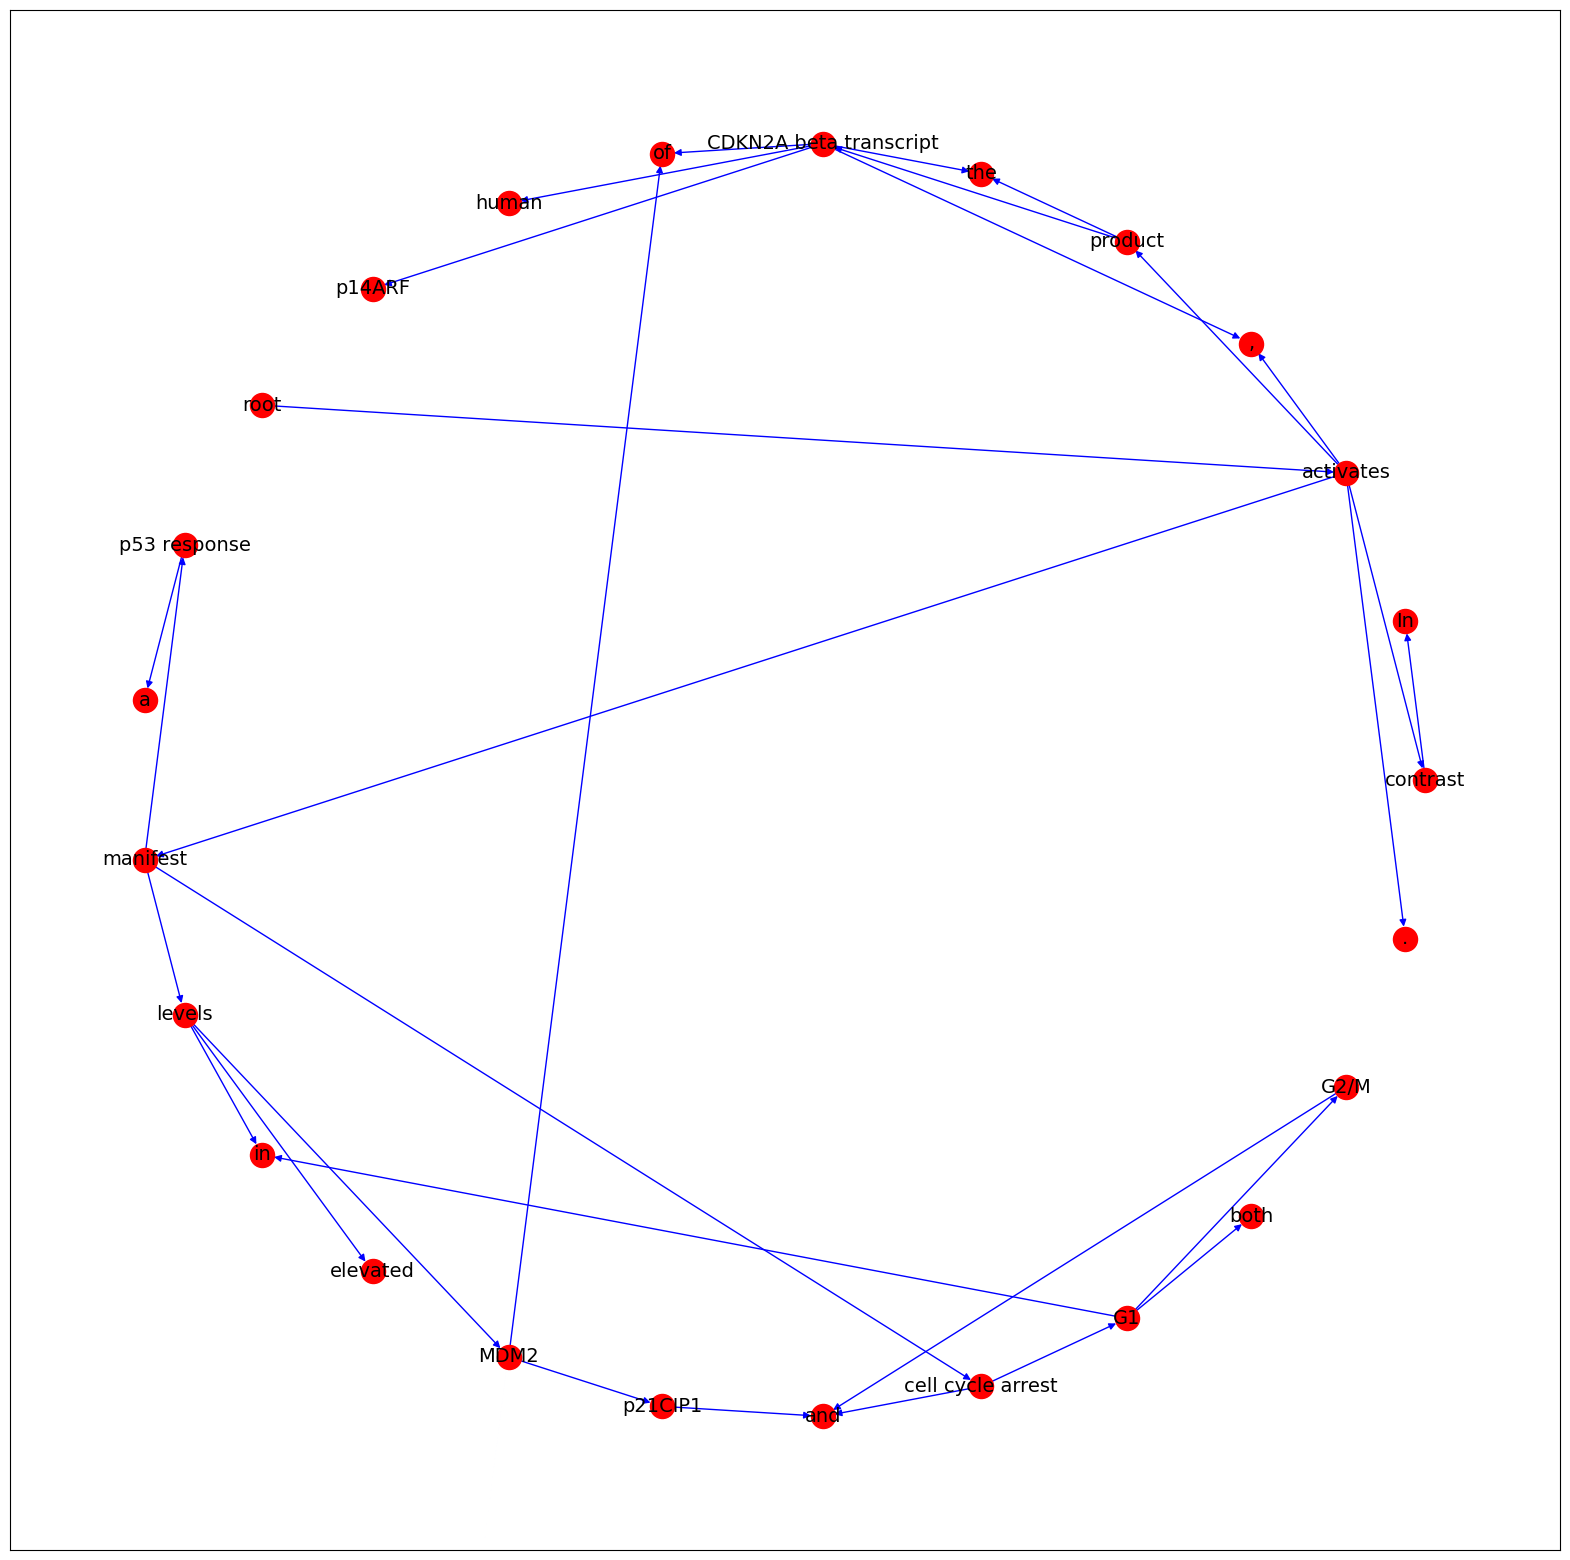

In [23]:
h = createDAG(pairs)
plot_circular_network(h)

In [43]:
nx.is_directed_acyclic_graph(h)

True

In [25]:
s = startNode(h)
print (startNode(h))

['root']


In [26]:
t = terminalNode(h)
print(terminalNode(h))

['In', ',', 'the', 'of', 'human', 'p14ARF', 'a', 'in', 'elevated', 'and', 'both', '.']


In [37]:
print(inBetweenNode(h))

['contrast', 'activates', 'product', 'CDKN2A beta transcript', 'p53 response', 'manifest', 'levels', 'MDM2', 'p21CIP1', 'cell cycle arrest', 'G1', 'G2/M']


In [39]:
paths = []
for start in s:
    for end in t:
        ps = nx.all_simple_paths(h, source=start, target=end)
        for p in ps:
            paths.append(p)

In [42]:
for p in paths:
    print (len(p), p)

4 ['root', 'activates', 'contrast', 'In']
3 ['root', 'activates', ',']
5 ['root', 'activates', 'product', 'CDKN2A beta transcript', ',']
4 ['root', 'activates', 'product', 'the']
5 ['root', 'activates', 'product', 'CDKN2A beta transcript', 'the']
5 ['root', 'activates', 'product', 'CDKN2A beta transcript', 'of']
6 ['root', 'activates', 'manifest', 'levels', 'MDM2', 'of']
5 ['root', 'activates', 'product', 'CDKN2A beta transcript', 'human']
5 ['root', 'activates', 'product', 'CDKN2A beta transcript', 'p14ARF']
5 ['root', 'activates', 'manifest', 'p53 response', 'a']
5 ['root', 'activates', 'manifest', 'levels', 'in']
6 ['root', 'activates', 'manifest', 'cell cycle arrest', 'G1', 'in']
5 ['root', 'activates', 'manifest', 'levels', 'elevated']
7 ['root', 'activates', 'manifest', 'levels', 'MDM2', 'p21CIP1', 'and']
5 ['root', 'activates', 'manifest', 'cell cycle arrest', 'and']
7 ['root', 'activates', 'manifest', 'cell cycle arrest', 'G1', 'G2/M', 'and']
6 ['root', 'activates', 'manifest',